In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from shutil import copyfile
from PIL import Image
import glob
import piexif
import sys
import os
import math
import random
import csv
import json
import ast
import datetime
from os import listdir
from os.path import isfile, join

csv.field_size_limit(sys.maxsize)

%matplotlib inline

In [2]:
def read_mnist_data(path, classes):
    """
        Reads MNIST dataset and returns:
        
        X: (N X M)
        Y: (C X M) (one-hot encoded)
        M: Total number of examples
        N: Total number of features
        
        Note: Dataset is read from local machine which in turn is retrieved from
        https://www.kaggle.com/c/digit-recognizer/data
    """
    
    # Read data
    df = pd.read_csv(path)
    cols = df.columns.tolist()
    
    # Extract data and convert to numpy arrays
    X = df[cols[1:]].values.T
    Y = df[cols[0]].values.T

    # Convert to one-hot encoding
    M = X.shape[1]
    one_hot_y = np.zeros((M, classes))
    one_hot_y[np.arange(M), Y] = 1
    Y = one_hot_y.T
    
    return X, Y, X.shape[1], X.shape[0]
    
def plot_mnist_example(X, Y, image_size, index=None):
    """
        Given X: (N X M) and Y: (C X M), and an optional
        index in the range (0, M-1), this function plots
        the corresponding image
        
        image_size: is the size of the image (i.e. width = height = image_size)
    """

    M = X.shape[1]
    if index == None:
        index = random.randint(0, M - 1) 
    image = X[:, index]
    image = image.reshape(image.shape[0], 1)
    print("Printing image no: " + str(index))
    image = image.reshape(image_size, image_size)
    label = Y[:,index]
    fig = plt.figure()
    plt.imshow(image)
    plt.title("Label: " + str(np.argmax(label)))

In [3]:
def split_dataset(x, y, train_per, dev_per, test_per):
    """
        Splits dataset (i.e. x, y) into 3 parts, specified by their percentages
        Example: split_dataset(x, y, 80, 10, 10) will split x and y into the following:
        
        train: 80%
        dev: 10%
        test: 10%
        
        Note: x and y should be ndarray's of size (N X M) and (C X M) respectively
        
        Note: You can give one of the percentage as 0. For instance, if you give (70, 0, 30), then
        dev set size will be zero!
    """

    new_x = x.T
    new_y = y.T
    
    rows = new_x.shape[0]
    cols = new_x.shape[1]
    
    combined = np.hstack((new_x, new_y))
    np.random.shuffle(combined)
    
    new_x = combined[:,:cols]
    new_y = combined[:,cols:]
    
    train_size = int((train_per / 100) * rows)
    dev_size = int((dev_per / 100) * rows)
    test_size = int((test_per / 100) * rows)

    print("Total size: " + str(rows) + " Train size: " + str(train_size) +
          " Dev size: " + str(dev_size) + " Test size: " + str(test_size))
    
    train_x = new_x[:train_size]
    dev_x = new_x[train_size:train_size + dev_size]
    test_x = new_x[train_size + dev_size:]
    
    train_y = new_y[:train_size]
    dev_y = new_y[train_size:train_size + dev_size]
    test_y = new_y[train_size + dev_size:]
    
    return (train_x.T, dev_x.T, test_x.T, train_y.T, dev_y.T, test_y.T)

In [4]:
def save_model(filename, X_train, X_dev, Y_train, Y_dev, M_train, M_dev,
               N, C, split, layers, activation_funcs, params,
               cost, cost_arr, alpha, iterations, accuracy_train, accuracy_dev):
    """
        Writes the model to a CSV file (In the form of a dictionary)
    """
    
    print("Saving model to file: " + filename)
    
    my_model = {}
    my_model["X_train_shape"] = X_train.shape
    my_model["Y_train_shape"] = Y_train.shape
    my_model["M_train"] = M_train
    my_model["X_dev_shape"] = X_dev.shape
    my_model["Y_dev_shape"] = Y_dev.shape
    my_model["M_dev"] = M_dev
    my_model["N"] = N
    my_model["C"] = C
    my_model["split"] = split
    my_model["layers"] = json.dumps(layers)
    my_model["activation_funcs"] = json.dumps(activation_funcs)
    
    simple_params = []
    for key, value in params.items():
        simple_param = {}
        simple_param["param_name"] = key
        simple_param["rows"] = value.shape[0]
        simple_param["cols"] = value.shape[1]
        simple_param["value"] = json.dumps(value.reshape(-1).tolist())
        simple_params.append(simple_param)
    my_model["params"] = json.dumps(simple_params)
    
    my_model["cost"] = cost
    my_model["cost_arr"] = json.dumps(cost_arr)
    my_model["alpha"] = alpha
    my_model["iterations"] = iterations
    my_model["accuracy_train"] = accuracy_train
    my_model["accuracy_dev"] = accuracy_dev
    
    with open(filename, 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in my_model.items():
           writer.writerow([key, value])

def read_model(filename):
    
    """
        Reads the model from the file 'filename'
        Note: The model should have been saved to this file
        in the format specified by save_model
    """
    
    print("Reading model from file: " + filename)
    
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file)
        my_model = dict(reader)
        
    my_model["X_train_shape"] = ast.literal_eval(my_model["X_train_shape"])
    my_model["Y_train_shape"] = ast.literal_eval(my_model["Y_train_shape"])
    my_model["M_train"] = int(my_model["M_train"])
    my_model["X_dev_shape"] = ast.literal_eval(my_model["X_dev_shape"])
    my_model["Y_dev_shape"] = ast.literal_eval(my_model["Y_dev_shape"])
    my_model["M_dev"] = int(my_model["M_dev"])
    my_model["N"] = int(my_model["N"])
    my_model["C"] = int(my_model["C"])
    my_model["split"] = ast.literal_eval(my_model["split"])
    my_model["layers"] = json.loads(my_model["layers"])
    my_model["activation_funcs"] = json.loads(my_model["activation_funcs"])
    
    my_model["params"] = json.loads(my_model["params"])
    params = {}
    for simple_param in my_model["params"]:
        np_list_value = np.array(json.loads(simple_param["value"]), dtype=np.float64)
        value = np_list_value.reshape(int(simple_param["rows"]), int(simple_param["cols"]))
        params[simple_param["param_name"]] = value
    my_model["params"] = params
        
    my_model["cost"] = float(my_model["cost"])
    my_model["cost_arr"] = json.loads(my_model["cost_arr"])
    my_model["alpha"] = float(my_model["alpha"])
    my_model["iterations"] = int(my_model["iterations"])
    my_model["accuracy_train"] = float(my_model["accuracy_train"])
    my_model["accuracy_dev"] = float(my_model["accuracy_dev"])
    
    return my_model

def print_model(model_dict, func_names):
    print("=" * 40)
    print("Layers : " + str(model_dict["layers"]))
    print_activation_function_names(func_names, model_dict["activation_funcs"])
    print("Alpha : " + str(model_dict["alpha"]))
    print("Iterations : " + str(model_dict["iterations"]))
    print("Cost : " + str(model_dict["cost"]))
    print("Accuracy(train) : " + str(model_dict["accuracy_train"]))
    print("Accuracy(dev) : " + str(model_dict["accuracy_dev"]))
    print("=" * 40)

In [5]:
def normalize(vec):
    """
        vec is a row/column vector
        Returns a normalized vector
    """
    mew = np.average(vec)
    std = np.std(vec)
    return (mew, std, (vec - mew)/std)

In [6]:
def de_normalize(mew, std, vec):
    """
        mew and std are numbers denoting the original mean and standard deviation of the vector
        Returns the denormalized vector
    """
    return ((vec * std) + mew) 

In [7]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    """
    return 1/(1 + np.exp(-z))

In [8]:
def sigmoid_derivative(z):
    """
    Applies the sigmoid-derivative on z
    """
    return sigmoid(z) * (1 - sigmoid(z))

In [9]:
def tanh(z):
    """
    Computes the tanh of z
    """
    return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))

In [10]:
def tanh_derivative(z):
    """
    Applies the tanh-derivative on z
    """
    return (1 - tanh(z)) ** 2

In [11]:
def relu(z):
    """
    Computes the Rectified Linear Unit of z
    """
    return np.maximum(z, 0)

In [12]:
def relu_derivative(z):
    """
    Applies the ReLU derivative on z
    """
    return (z > 0).astype(np.float)

In [13]:
def leaky_relu(z):
    """
    Computes the Leaky Rectified Linear Unit of z
    """
    return np.maximum(z, 0.01 * z)

In [14]:
def leaky_relu_derivative(z):
    """
    Applies the leaky_ReLU derivative on z
    """
    f = np.vectorize(lambda x : 1 if x > 0 else 0.01, otypes=[np.float])
    return f(z)

In [15]:
def print_activation_function_names(func_names, indices):
    print("Activation functions: ", end="")
    for i in range(len(indices)):
        print(func_names[indices[i]].__name__, end="")
        if i != (len(indices) - 1):
            print(" -> ", end="")
    print("")

In [16]:
def initialize_model(layer_sizes):
    """
        Initializes the neural network model
        
        Input is a list containing the lengths of the layer
    """
    
    assert(len(layer_sizes) >= 2)
    parameters = {}
    
    # initialize the parameters
    for i in range(1, len(layer_sizes)):
        parameters["W" + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * 0.01
        parameters["b" + str(i)] = np.zeros((layer_sizes[i], 1))
        
    return parameters

def unit_test_initialize_model():
    layers = [2, 3, 10, 10, 3, 1]
    params = initialize_model(layers)
    for i in range(1, len(layers)):
        W = params['W' + str(i)]
        b = params['b' + str(i)]
        print("Shape of W" + str(i) + " is: " + str(W.shape) + " and b" + str(i) + " is: " + str(b.shape))
        
# unit_test_initialize_model()

In [17]:
def forward_propagate(X, parameters, layer_sizes, funcs, activation_funcs):
    """
        X -- of size (N X M)
        parameters -- a dictionary of W's and b's of appropriate shapes
        layer_sizes -- a list of layer sizes of the network
        funcs -- list of available activation functions (i.e. an array of functions)
        activation_funcs -- list of activation functions (i.e. an index into func_names)
        
        returns the final activation result and caches tuple, which holds all intermediate results
        useful for backprop
    """
    
    assert((len(layer_sizes) >= 2) and (len(activation_funcs) == (len(layer_sizes) - 1)))
    
    # feed-forward propagation
    prev_A = X
    caches = []
    for i in range(1, len(layer_sizes)):

        W = parameters["W" + str(i)]
        b = parameters["b" + str(i)]
        
        Z = W @ prev_A + b
        
        linear_cache = prev_A, W, b
        activation_cache = Z
        
        A = funcs[activation_funcs[i - 1]](Z)
        
        
        cache = linear_cache, activation_cache
        caches.append(cache)

        prev_A = A
        
    return prev_A, caches

def unit_test_forward_propagate():
    X = np.random.randn(3, 5)
    layers = [3, 4, 2, 1]
    parameters = initialize_model(layers)
    funcs = [sigmoid, tanh, relu, leaky_relu]
    activation_funcs = [1, 2, 3]
    final_activation, caches = forward_propagate(X, parameters, layers, funcs, activation_funcs)
    for i in range(1, len(layers)):
        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]
        print("Shape of W" + str(i) + " is: " + str(W.shape) + " and b" + str(i) + " is: " + str(b.shape))
        print(W)
        print(b)
        linear_cache, activation_cache = caches[i - 1]
        A, W, b = linear_cache
        Z = activation_cache
        print("Linear cache A is: ")
        print(A)
        print("Activation cache is: ")
        print(Z)

    print("Final activation is: ")
    print(final_activation)
    
# unit_test_forward_propagate()

In [18]:
def cross_entropy_cost(A, Y):
    """
    Computes the standard cross entropy cost on A (of size CXM) and Y of size (CXM), where C is no:of classes
    """
    M = A.shape[1]
    cost = (-1/M) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A), axis=1, keepdims=True)
    """
        The above cost array will be of size (C X 1)
        We need average cost since we are doing multi-class classification
    """
    avg_cost = np.squeeze(np.mean(cost))
    return avg_cost

def cross_entropy_derivative(A, Y):
    """
        Computes the derivative of cross_entropy_loss function with respect to the last layer
        activations
    """
    M = A.shape[1]
    return (-1) * (np.divide(Y, A) - np.divide(1 - Y, 1 - A))

def unit_test_cross_entropy_cost():
    a = np.array([0.1, 0.1]).reshape(1, 2)
    b = np.array([0.9, 0.9]).reshape(1, 2)
    print(a)
    print(b)
    print(cross_entropy_cost(a, b))
    
# unit_test_cross_entropy_cost()

In [19]:
def backward_propagate(AL, Y, caches, derivative_funcs, activation_funcs, cost_func_derivative):
    """
    Computes backward propagation on a neural network, given:
    
    AL: Activations of last layer (C X M) where C is the no:of classes
    Y: Actual output values (C X M)
    caches: Intermediate results accumulated during forward propagation
    derivative_funcs -- derivative functions of list of available activation functions (i.e. an array of functions)
    activation_funcs -- list of activation functions (i.e. an index into func_names)
        
    returns a dictionary of gradients
    """
    
    grads = {}
    assert(len(caches) >= 1)
    assert(Y.shape == AL.shape)
    
    L = len(caches)
    m = Y.shape[1]
    linear_cache, activation_cache = caches[L - 1]
    A_prev, W, b = linear_cache

    # Differentiation of the cross_entropy loss function with respect to 'AL' (i.e. the last layer activations)
    dAL = cost_func_derivative(AL, Y)    
    dZL = dAL * derivative_funcs[activation_funcs[L-1]](activation_cache)
    grads["dW" + str(L)] = (1/m) * (dZL @ A_prev.T)
    grads["db" + str(L)] = (1/m) * np.sum(dZL, axis=1, keepdims=True)
    grads["dA" + str(L - 1)] = (W.T @ dZL)
    
    # Loop from l=L-2 to l=0 inclusive
    for l in reversed(range(L-1)):
        
        cache = caches[l]
        linear_cache, activation_cache = cache
        A_prev, W, b = linear_cache

        dZ = grads["dA" + str(l + 1)] * derivative_funcs[activation_funcs[l]](activation_cache)
        grads["dW" + str(l + 1)] = (1/m) * (dZ @ A_prev.T)
        grads["db" + str(l + 1)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        grads["dA" + str(l)] = (W.T @ dZ)
        

    return grads

In [20]:
def update_parameters(parameters, grads, learning_rate):
    """
        Update parameters using gradient descent

        Arguments:
        params - dictionary containing parameters 
        grads - dictionary containing gradients

        Returns: updated parameter dictionary
    """
    
    # get the number of layers in the neural network
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [21]:
def model(X, Y, learning_rate, layers, iterations, funcs, derivative_funcs, activation_funcs,
          cost_func=cross_entropy_cost, cost_func_derivative=cross_entropy_derivative):
    """
        X - input feature vector of size (N X M)
        Y - output label of size (1 X M)
        
        learning_rate - alpha
        layers - a python list denoting the layers of the network
        iterations - number of iterations to run gradient descent
        funcs - list of activation functions (function pointers)
        derivative_funcs - list of derivative functions of the activation functions (function pointers)
        activation_funcs - list, denoting which activation function to be used on each layer
        cost_func - the cost function which has to be used for fitting the model
        
        returns the parameter dictionary containing the weights of the learned model and the corresponding cost
    """
    
    """
        General procedure for learning:

        1. Initialize parameters
        2. Loop for num_iterations:
            a. Forward propagation
            b. Compute cost function
            c. Backward propagation
            d. Update parameters (using parameters, and grads from backprop)

    """
    
    params = initialize_model(layers)
    cost_arr = []
    
    i = 0
    while i != iterations:
        
        AL, caches = forward_propagate(X, params, layers, funcs, activation_funcs)
        cost = cost_func(AL, Y)
        cost_arr.append(cost)

        if i % 100 == 0:
            print("At " + str(i) + "th iteration, cost is: " + str(cost))
            
        grads = backward_propagate(AL, Y, caches, derivative_funcs, activation_funcs, cost_func_derivative)
        params = update_parameters(params, grads, learning_rate)
        
        i = i + 1
    
    fig = plt.figure()
    plt.plot(cost_arr)
    plt.ylabel("Cross entropy cost")
    plt.xlabel("iterations")
    plt.title("Gradient descent progress")
    
    return params, cost_arr[-1], cost_arr

In [22]:
def predict(X, Y, params, layers, funcs, activation_funcs, classes):
    '''
        Performs the prediction, given the weights of the model (by doing a forward propagation)
        The predicted results are then compared with the actual values (1's and 0's) present in 'Y'
        
        Before comparing with 'Y', the predicted results are classified as 1 if activation value is > 0
        else as 0
        
        layers - the layers present in model (as a python list)
        funcs - list of activation functions (function pointers)
        activation_funcs - list, denoting which activation function to be used on each layer
        
        Returns the prediction results and the accuracy
    '''
    
    AL, caches = forward_propagate(X, params, layers, funcs, activation_funcs)
    
    predictions = np.argmax(AL, axis=0)
    actual_values = np.argmax(Y, axis=0)
    
    accuracy = np.mean(np.equal(predictions, actual_values)) * 100

    M = X.shape[1]
    Y_prediction = np.zeros((M, classes))
    Y_prediction[np.arange(M), predictions] = 1
    Y_prediction = Y_prediction.T
    Y_prediction = Y_prediction.astype(int)
    
    return Y_prediction, accuracy

In [27]:
def print_incorrectly_labelled_examples(X, Y, Y_prediction, image_size):
    """
        Given X: (N X M), Y and Y_prediction: (C X M), this functions prints few of the
        incorrectly labelled examples
        
        Note: Y_prediction is the predicted output of the model, corresponding to X and Y
    """
    
    # Extract the mismatches
    predictions = np.argmax(Y_prediction, axis=0)
    actual_values = np.argmax(Y, axis=0)
    mismatches = np.flatnonzero(np.logical_not(np.equal(predictions, actual_values)))
    print("Total mislabelled examples are: " + str(mismatches.size) + " out of: " + str(Y.shape[1]))
    
    if(mismatches.size != 0):
        # Randomly select an index which is mismatched
        index = mismatches[random.randint(0, mismatches.size - 1)]
        
        # Print the predicted label, which is incorrect
        predicted_label = Y_prediction[:,index]
        
        image = X[:, index]
        image = image.reshape(image.shape[0], 1)
        image = image.reshape(image_size, image_size)
        label = Y[:,index]
        fig = plt.figure()
        plt.imshow(image)
        plt.title("Actual Label: " + str(np.argmax(label)) + " Predicted: " + str(np.argmax(predicted_label)))
        
    else:
        print("No incorrectly labelled examples found!")

Total examples (M): 42000
Total no:of features (N): 784
X: (784, 42000)
Y: (10, 42000)
Total size: 42000 Train size: 29399 Dev size: 8400 Test size: 4200
X_train: (784, 29399)
X_dev: (784, 8400)
X_test: (784, 4201)
Y_train: (10, 29399)
Y_dev: (10, 8400)
Y_test: (10, 4201)
Printing image no: 7584
At 0th iteration, cost is: 0.677669531223948
At 100th iteration, cost is: 0.11577315282910994
At 200th iteration, cost is: 0.0896096599204593
At 300th iteration, cost is: 0.07860747378288085
At 400th iteration, cost is: 0.07190868310064268
At 500th iteration, cost is: 0.06767659296667741
At 600th iteration, cost is: 0.06468084845310607
At 700th iteration, cost is: 0.062320607375849726
At 800th iteration, cost is: 0.06041873931417867
At 900th iteration, cost is: 0.05885107437788596
At 1000th iteration, cost is: 0.05753901294741629
At 1100th iteration, cost is: 0.05640414976892849
At 1200th iteration, cost is: 0.0554131335471435
At 1300th iteration, cost is: 0.05452702515028487
At 1400th iteratio

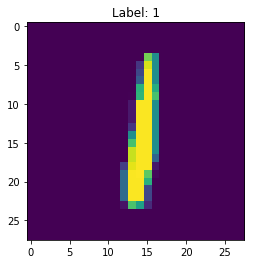

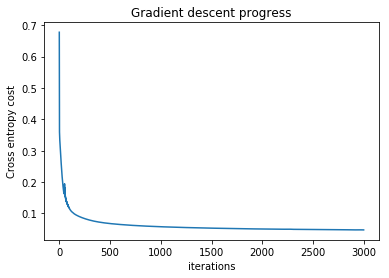

In [24]:
# Read the dataset
path = './mnist/train.csv'
image_size = 28
classes = 10
X, Y, M, N = read_mnist_data(path, classes)
print("Total examples (M): " + str(M))
print("Total no:of features (N): " + str(N))
print("X: " + str(X.shape))
print("Y: " + str(Y.shape))

# Dataset parameters
train_per = 70
dev_per = 20
test_per = 10
split = (train_per, dev_per, test_per)

# Split the dataset
split = (train_per, dev_per, test_per)
(X_train, X_dev, X_test, Y_train, Y_dev, Y_test) = split_dataset(X, Y, train_per, dev_per, test_per)

M_train = X_train.shape[1]
M_dev = X_dev.shape[1]

print("X_train: " + str(X_train.shape))
print("X_dev: " + str(X_dev.shape))
print("X_test: " + str(X_test.shape))
print("Y_train: " + str(Y_train.shape))
print("Y_dev: " + str(Y_dev.shape))
print("Y_test: " + str(Y_test.shape))

# Plot some random image from training set
plot_mnist_example(X_train, Y_train, image_size)

"""
Total examples (M): 42000
Total no:of features (N): 784
X: (784, 42000)
Y: (10, 42000)
Total size: 42000 Train size: 29399 Dev size: 8400 Test size: 4200
X_train: (784, 29399)
X_dev: (784, 8400)
X_test: (784, 4201)
Y_train: (10, 29399)
Y_dev: (10, 8400)
Y_test: (10, 4201)
"""

funcs = [sigmoid, tanh, relu, leaky_relu]
derivative_funcs = [sigmoid_derivative, tanh_derivative, relu_derivative, leaky_relu_derivative]

# Network parameters
layers = [784, 10, 10]
activation_funcs = [2, 0]
alpha = 0.001
iterations = 3000

params, cost, cost_arr = model(X_train, Y_train, alpha, layers, iterations, funcs,
                                   derivative_funcs, activation_funcs, cost_func=cross_entropy_cost,
                                   cost_func_derivative=cross_entropy_derivative)

# Results
print("\n\n" + ("*" * 40))
print("Train Examples: " + str(M_train))
print("Layers: " + str(layers))
print_activation_function_names(funcs, activation_funcs)
print("Alpha: " + str(alpha) + " iterations: " + str(iterations))
print("Min cost is: " + str(cost))
Y_prediction_train, accuracy_train = predict(X_train, Y_train, params, layers, funcs, activation_funcs, classes)
Y_prediction_dev, accuracy_dev = predict(X_dev, Y_dev, params, layers, funcs, activation_funcs, classes)
print("Accuracy on train set: " + str(accuracy_train))
print("Accuracy on dev set: " + str(accuracy_dev))
print(("*" * 40) + "\n\n")

# Save the model to disk
filename = 'model_' + '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()) + '.csv'
save_model(filename, X_train, X_dev, Y_train, Y_dev, M_train, M_dev,
           N, classes, split, layers, activation_funcs, params,
           cost, cost_arr, alpha, iterations, accuracy_train, accuracy_dev)

Reading model from file: ./model_2019_01_28_16_36_20.csv
Layers : [784, 10, 10]
Activation functions: relu -> sigmoid
Alpha : 0.001
Iterations : 3000
Cost : 0.04740753102287099
Accuracy(train) : 93.71067043096704
Accuracy(dev) : 92.34523809523809
Total mislabelled examples are: 643 out of: 8400


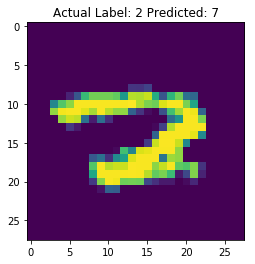

In [35]:
# Read the model from disk (and analyze it)
filename = './model_2019_01_28_16_36_20.csv'
model_read_from_file = read_model(filename)
print_model(model_read_from_file, funcs)


# Analysis of incorrectly labelled images
print_incorrectly_labelled_examples(X_dev, Y_dev, Y_prediction_dev, image_size)